# Machine Problem  
Nathaniel Cruel and Renzo Virtucio  
Department of Computer Science, University of the Philippines Diliman  
CS 180: Artificial Intelligence  
Professor Carlo Raquel  
June 15, 2021
***

## Introduction to the Problem
Academic performance has long been a top priority of academic institutions and its constituents, which includes the faculty and the students, as this is used as one of the measurements of their success. Intuitively, a student’s academic performance is often attributed to the similarly academic parameters such as the total number of hours spent on studying for a written assessment, the researchers wanted to determine if there exists an underlying pattern, which can be identified by machine learning, in the relationship between a student’s academic performance and other, possibly inconspicuous, factors found in their demographics, academic profile and social profile.
## Rationale
A student’s experience in school cannot be limited only to their academics, so plenty of other factors may affect their academic performance. Since student demographics, academic profile and social profile are readily available as these are collected at the time of enrollment, evaluating these data may provide valuable insight into how academic institutions and their constituents may be able to address the concern of improving or addressing a student’s academic performance.
## Objective
The objective of this project is to train a Support Vector Machine (SVM) on the Student Performance dataset so that it can predict the final grades of high school students in Mathematics by analyzing 33 attributes describing the students’ demographics and their academic and social profiles.

## Methodology
This project used a Principal Component Analysis and Support Vector Machine (SVM) in a pipeline to predict the classification over the Student Math Performance dataset by Paulo Cortez and Alice Silva published in the UCI Machine Learning Repository using attributes describing the students’ demographics and their academic and social profiles. The dataset was collected through school reports and questionnaires. The complete list of attributes are as follows:

1. school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2. sex - student's sex (binary: "F" - female or "M" - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: "U" - urban or "R" - rural)
5. famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6. Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
10. Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
12. guardian - student's guardian (nominal: "mother", "father" or "other")
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)
31. G1 - first period grade (numeric: from 0 to 20)
32. G2 - second period grade (numeric: from 0 to 20)
33. G3 - final grade (numeric: from 0 to 20, output target)

This dataset can be accessed [here](https://archive.ics.uci.edu/ml/datasets/student+performance).

## Data and Analysis
### Training the Support Vector Machine Classifier

The spreedsheet student-mat.csv is read. The dataset is inputted into the variable students_math. The contents of the dataset can be seen below.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# Create dataframe
students_math = pd.read_csv('student/student-mat.csv', delimiter=';', header=0)
display(students_math)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


The dataset undergoes preprocessing before analysis. First, binary attributes are encoded to binary categorical data (0 and 1) while nominal attributes are encoded by adding dummy columns for the possible values of each attribute.

Furthermore, a new column/attribute called Quality is added to the dataset. The value of this attribute depends on the value of attribute G3. If G3 is GREATER THAN OR EQUAL TO 12 (60% of 20, the highest possible value of G3), then QUALITY is set to 1 (HIGH grade). If G3 is greater than 0 but less than 12, then QUALITY is 0 (LOW grade).

This binary attribute will serve as the target output in the analysis, as it is ideal for the Support Vector Machine (SVM) algorithm to be used.

In [2]:
## PREPROCESSING ##
# Encoding binary attributes
students_math.school = students_math.school.map({"GP":0, "MS":1})
students_math.sex = students_math.sex.map({"F":0, "M":1})
students_math.address = students_math.address.map({"U":0, "R":1})
students_math.famsize = students_math.famsize.map({"LE3":0, "GT3":1})
students_math.Pstatus = students_math.Pstatus.map({"T":0, "A":1})
students_math.schoolsup = students_math.schoolsup.map({"yes":0, "no":1})
students_math.famsup = students_math.famsup.map({"yes":0, "no":1})
students_math.paid = students_math.paid.map({"yes":0, "no":1})
students_math.activities = students_math.activities.map({"yes":0, "no":1})
students_math.nursery = students_math.nursery.map({"yes":0, "no":1})
students_math.higher = students_math.higher.map({"yes":0, "no":1})
students_math.internet = students_math.internet.map({"yes":0, "no":1})
students_math.romantic = students_math.romantic.map({"yes":0, "no":1})

# Encoding nominal attributes
job_types = ["teacher", "health", "services", "at_home", "other"]
reason_types = ["home", "reputation", "course", "other"]
guardian_types = ["mother", "father", "other"]
Mjob_dum = pd.get_dummies(students_math['Mjob'], prefix='Mjob')
Fjob_dum = pd.get_dummies(students_math['Fjob'], prefix='Fjob')
reason_dum = pd.get_dummies(students_math['reason'], prefix='reason')
guardian_dum = pd.get_dummies(students_math['guardian'], prefix='guardian')

students_math = pd.concat([students_math, Mjob_dum, Fjob_dum, reason_dum, guardian_dum], axis=1)
students_math.drop(['Mjob', 'Fjob', 'reason', 'guardian'], axis=1, inplace=True)
students_math

# Add a column describing if G3 (final grade) is high or low
# High = 12-20 (60% of 20 and above)
# Low = 0-11 (below 60% of 20)
students_math["quality"] = (students_math.G3 >= 12).map({True: 1, False: 0})
display(students_math)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,quality
0,0,0,18,0,1,1,4,4,2,2,...,0,1,1,0,0,0,0,1,0,0
1,0,0,17,0,1,0,1,1,1,2,...,0,0,1,0,0,0,1,0,0,0
2,0,0,15,0,0,0,1,1,1,2,...,0,0,0,0,1,0,0,1,0,0
3,0,0,15,0,1,0,4,2,1,3,...,1,0,0,1,0,0,0,1,0,1
4,0,0,16,0,1,0,3,3,1,2,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,1,2,...,1,0,1,0,0,0,0,0,1,0
391,1,1,17,0,0,0,3,1,2,1,...,1,0,1,0,0,0,0,1,0,1
392,1,1,21,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
393,1,1,18,1,0,0,3,2,3,1,...,0,0,1,0,0,0,0,1,0,0


To examine the correlation levels of the attributes with respect to one another and with respect to the target variable, Quality, a correlation heatmap is plotted.

Figure 1. Correlation Matrix Heatmap of Student Performance Dataset


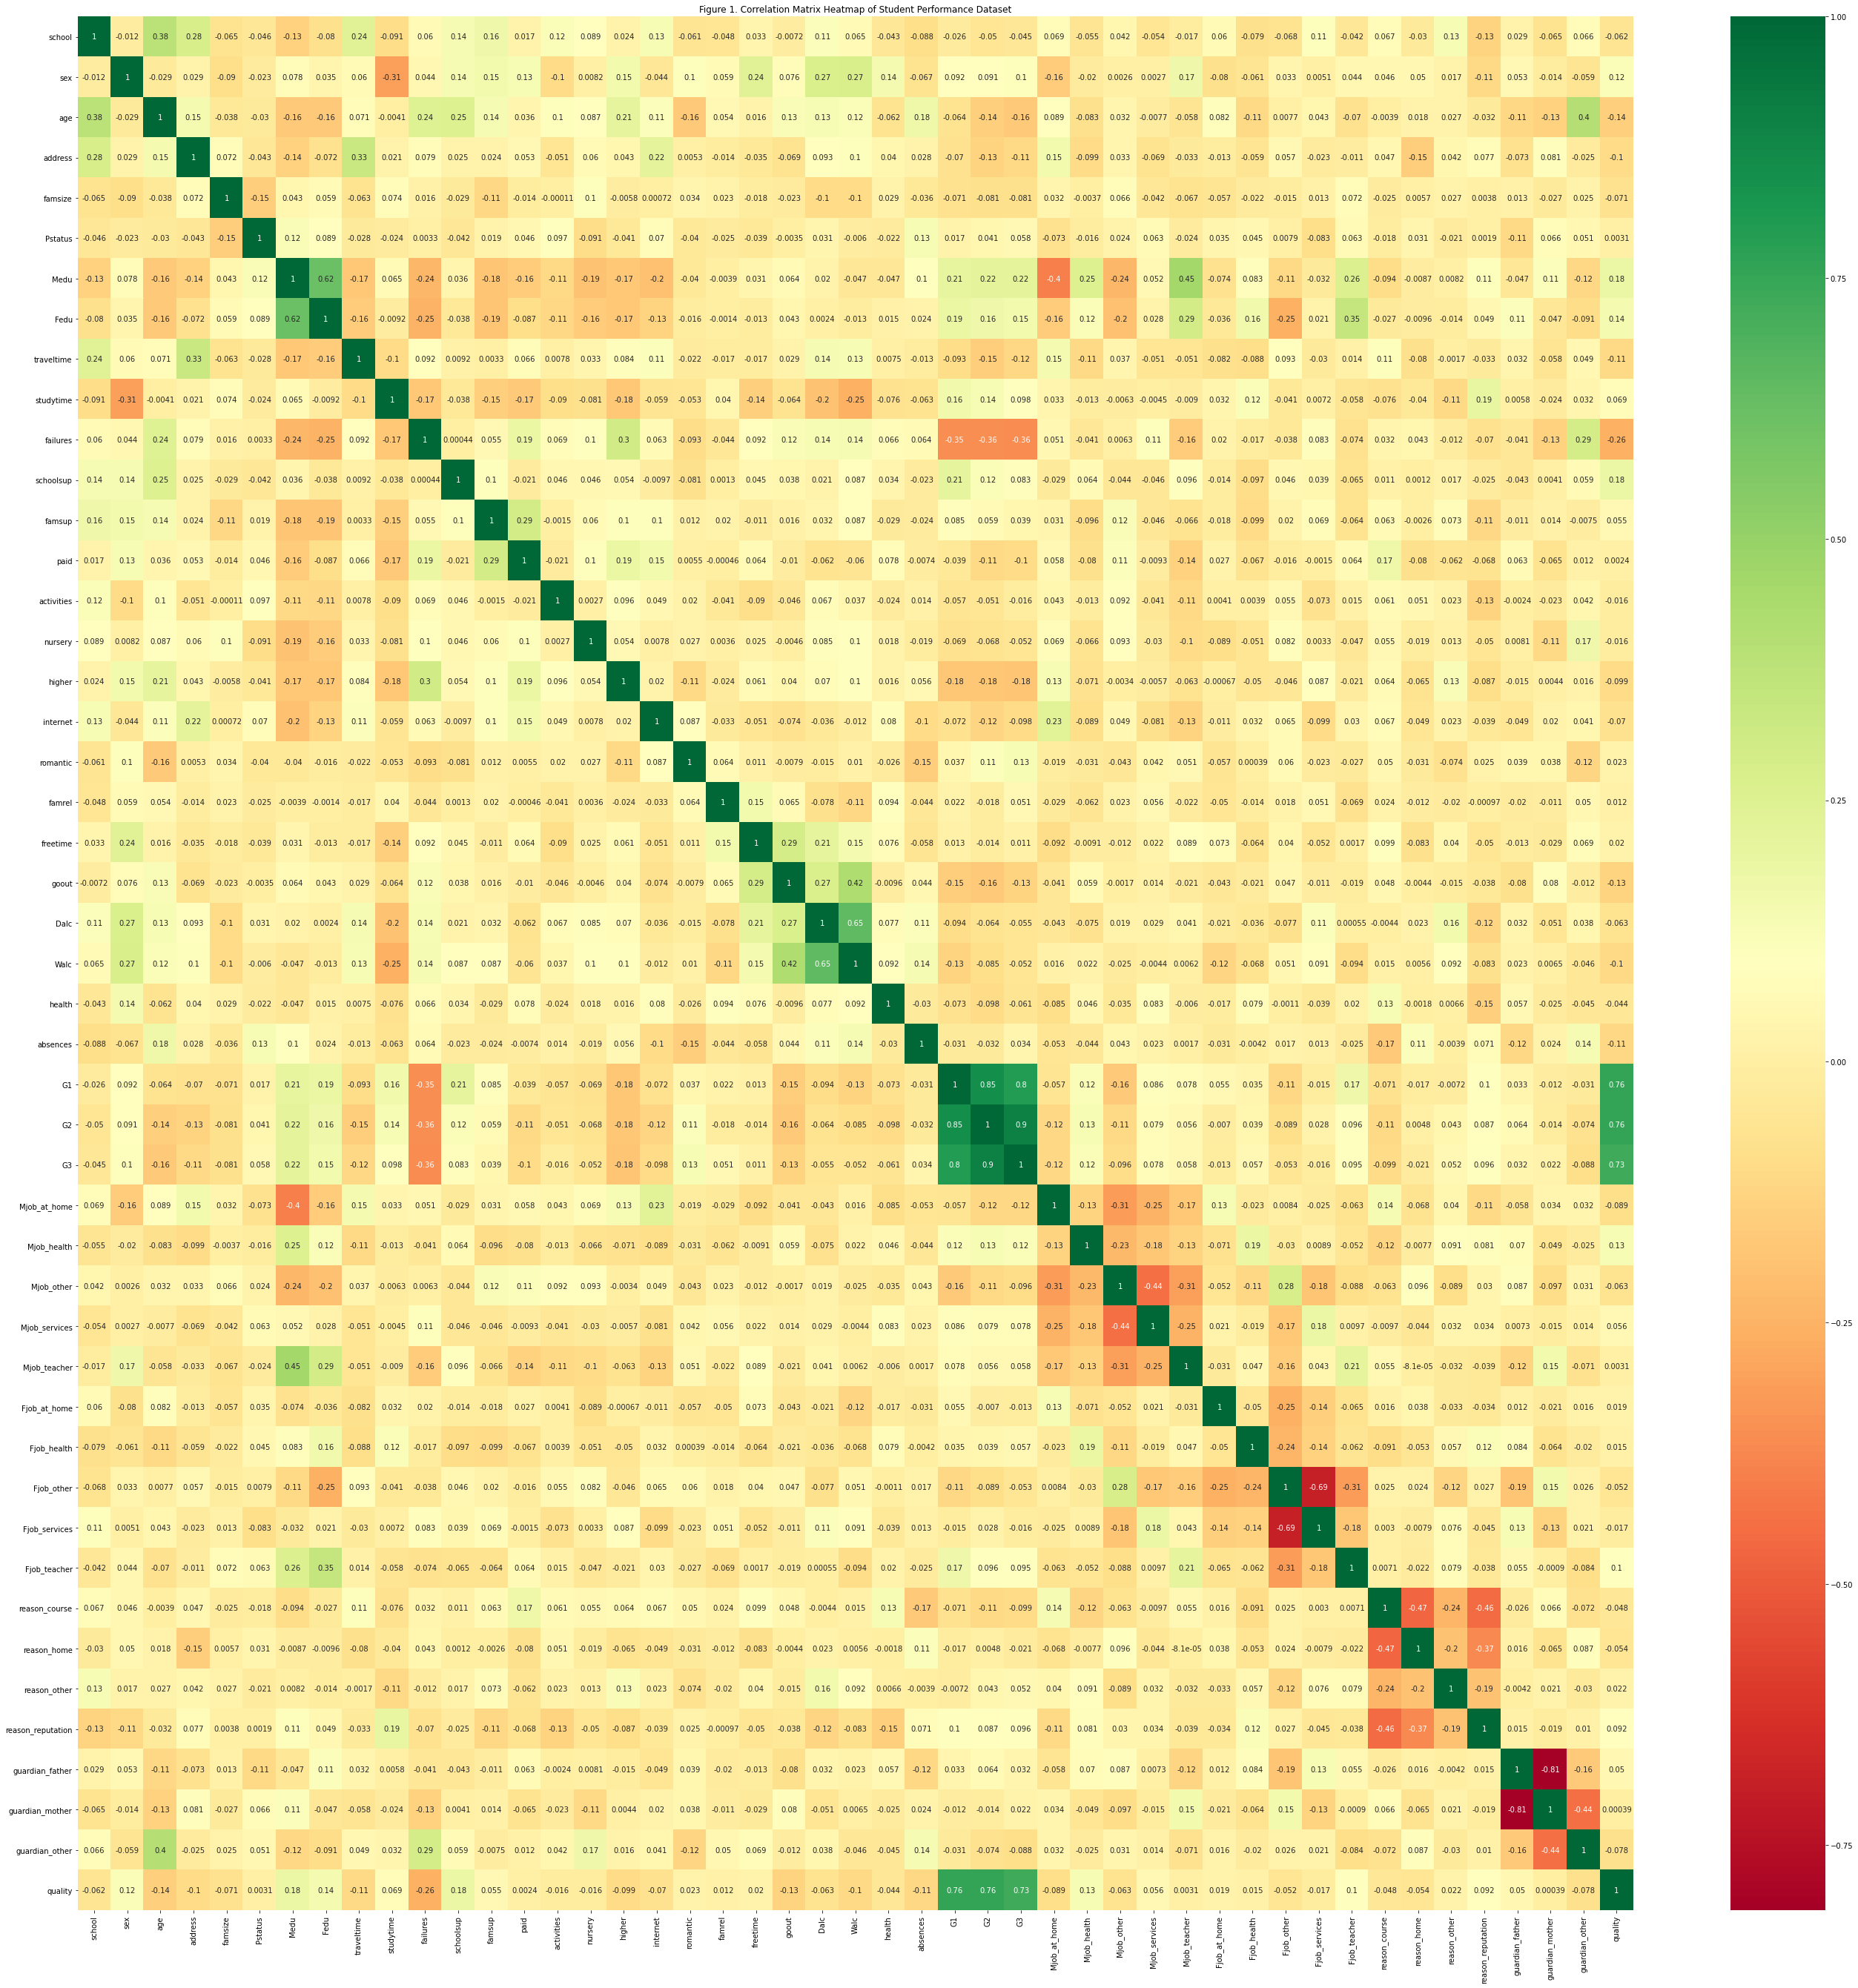

In [3]:
#Determine correlation per two variables
corrmat = students_math.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(47,47))
plt.title("Figure 1. Correlation Matrix Heatmap of Student Performance Dataset")

# Plot heat map
print("Figure 1. Correlation Matrix Heatmap of Student Performance Dataset")
g=sns.heatmap(students_math[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The correlation heatmap above shows that the attributes G1 (grade in 1st period), G2 (grade in 2nd period), are highly correlated to G3 and the target output, Quality.

In [4]:
# Define X and y for testing and training
y = students_math['quality']
# Drop G3 and the target variable, Quality
X = students_math.drop(['quality', 'G3'], axis=1)  
print(X.shape, y.shape)

(395, 45) (395,)


We set the target column, y, to be the 'quality' column of the students_math dataframe, and set the data, X, to be the students_math dataframe without the columns 'quality' and 'G3'. 'G3' is removed since it is already interpreted by the target variable 'quality'.

In [5]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Compute for the Variance Inflation Factor of each variable
calculate_vif(X)

<ipython-input-5-d40687b2c236>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
44,guardian_other,inf
37,Fjob_teacher,inf
28,Mjob_at_home,inf
29,Mjob_health,inf
30,Mjob_other,inf
31,Mjob_services,inf
32,Mjob_teacher,inf
33,Fjob_at_home,inf
34,Fjob_health,inf
35,Fjob_other,inf


We observe that the variance inflation factor of multiple variables are extremely high, some approaching infinity. Thus, there is a presence of multicollinearity which poses a problem as this undermines the statistical significance of supposedly independent variables.  

To address multicollinearity within the data, we utilize Principal Component Analysis which employs matrix factorization to reduce the dimensionality of data into lower space that still contains most of the information in the larger set.

Text(0, 0.5, 'cumulative explained variance')

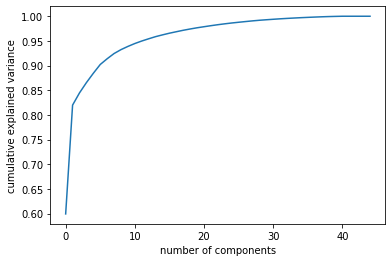

In [6]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We observe that at 10 components, the cumulative explained variance already reaches 0.90. Thus, we decided to use 15 components.

In [7]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=15)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
display(X)
# Compute for the Variance Inflation Factor of each variable
calculate_vif(X)  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.284742,-0.647852,-1.109581,1.897002,-3.246518,0.337670,0.154501,3.539507,0.173194,2.165701,0.434308,1.239617,-0.157741,-0.224663,1.532952
1,2.360940,-2.343682,0.932969,0.684109,-0.798861,2.164283,0.035296,-0.129017,-0.610059,-1.692665,1.364112,0.090787,-0.121168,-0.552833,1.234922
2,2.432180,-1.006324,-0.585227,-0.238424,-1.886461,-0.125358,-0.550358,-1.195837,3.314777,0.520005,0.873886,-0.256619,-0.080436,0.902759,1.214564
3,-3.217998,-0.877357,1.113702,-0.473125,-0.545260,-0.851075,-0.500141,-0.372490,1.759244,-1.649401,0.685752,-1.840319,-0.341759,-0.376215,-1.436220
4,-0.002635,-1.740317,0.594729,-1.504727,0.550351,2.274995,0.774671,1.639001,1.035238,-1.102394,0.333565,0.408023,-1.228818,-0.056273,-0.931202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.509560,3.918943,2.148252,-0.847498,-0.250184,-2.159434,-0.902756,-0.273656,-1.639500,0.906436,1.613708,3.442688,-1.174664,-1.527099,-1.232792
391,1.466891,3.417234,0.242965,2.200963,1.732529,-1.229775,-0.760097,-1.589211,1.116421,0.014432,-0.460002,1.304160,0.610327,-1.920030,1.013891
392,6.410825,0.959405,1.152580,-0.017686,2.221073,-0.939097,0.417130,1.058909,-3.240732,0.253002,1.012166,-0.176342,-1.538107,-0.117169,-0.036715
393,2.581032,2.033003,-1.051466,2.665786,1.908203,-0.640583,0.771240,-0.475771,-0.273811,0.737253,-0.272069,1.319891,-1.809733,-1.464283,-1.095945


,Var,Vif
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
6,6.0,1.0
7,7.0,1.0
8,8.0,1.0
9,9.0,1.0


We observe that the variance inflation factor of the principal components are now low (and uniform) at the value 1.0. Thus, there is no more multicollinearity in the data.

Next, we split the data for testing and training. A test size of 0.3 is used, which means that 30% of the dataset is to be utilized for testing the model. Then, the support vector machine is implemented.

Accuracy: 0.8907563025210085


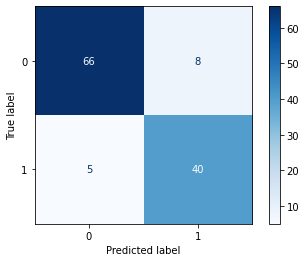

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        74
           1       0.83      0.89      0.86        45

    accuracy                           0.89       119
   macro avg       0.88      0.89      0.89       119
weighted avg       0.89      0.89      0.89       119



In [8]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC(random_state=0)
model.fit(X_train, y_train)


# Compute model predictions
model_predictions = model.predict(X_test)

orig_acc_score_no_grid = accuracy_score(y_test, model_predictions)
print("Accuracy:", orig_acc_score_no_grid)

# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, model_predictions))

Given the confusion matrix and classification report of the support vector machine, SVC, with default parameters, we observe that this has an accuracy of 0.89. We attempt to increase this by hyper-parameter tuning using GridSearchCV.

In [9]:
# Use GridSearchCV to optimize the parameters of SVC
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ('linear', 'rbf', 'poly', 'sigmoid')} 

# Create grid object
grid = GridSearchCV(SVC(random_state=0), param_grid, refit = True, verbose = 3, n_jobs=-1)
  
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             verbose=3)

### Cross Validation


The GridSearchCV method already performs K-fold cross validation. We show below the mean test scores computed by the cross validation procedure in GridSearchCV. 

In [10]:
# Print mean test scores from the results of cross validation in GridSearchCV

orig_acc_cv_results = grid.cv_results_['mean_test_score']

print(orig_acc_cv_results)

[0.83733766 0.5761039  0.81928571 0.75753247 0.83733766 0.5761039
 0.83720779 0.82292208 0.83733766 0.58694805 0.5761039  0.58694805
 0.83733766 0.5761039  0.5761039  0.5761039  0.83733766 0.5761039
 0.5761039  0.5761039  0.83727273 0.5761039  0.81928571 0.73961039
 0.83727273 0.81201299 0.81928571 0.77915584 0.83727273 0.83019481
 0.5761039  0.83746753 0.83727273 0.75753247 0.5761039  0.58694805
 0.83727273 0.5761039  0.5761039  0.5761039  0.85181818 0.5761039
 0.81928571 0.69590909 0.85181818 0.79025974 0.81928571 0.76474026
 0.85181818 0.8374026  0.63772727 0.83733766 0.85181818 0.84467532
 0.5761039  0.83746753 0.85181818 0.76116883 0.5761039  0.58694805
 0.84824675 0.5761039  0.81928571 0.69974026 0.84824675 0.79025974
 0.81928571 0.74662338 0.84824675 0.8188961  0.83720779 0.82292208
 0.84824675 0.84461039 0.5761039  0.83733766 0.84824675 0.84467532
 0.5761039  0.83746753 0.84461039 0.5761039  0.81928571 0.69974026
 0.84461039 0.79025974 0.81928571 0.73201299 0.84461039 0.8261039

### Continuation of GridSearchCV

In [11]:
# Print best parameter after tuning
print(grid.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, gamma=1, kernel='linear', random_state=0)


The SVC model tuned by GridSearchCV has parameters C=10, gamma=1 and kernel='linear'. We now use this model on the test set and observe for increase in accuracy.

Accuracy: 0.8907563025210085


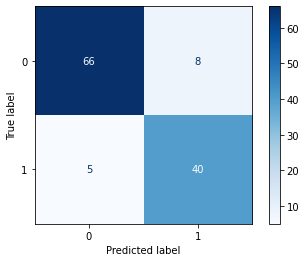

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        74
           1       0.83      0.89      0.86        45

    accuracy                           0.89       119
   macro avg       0.88      0.89      0.89       119
weighted avg       0.89      0.89      0.89       119



In [12]:
# Compute grid predictions
grid_predictions = grid.predict(X_test)

orig_acc_score_with_grid = accuracy_score(y_test, grid_predictions)
print("Accuracy:", orig_acc_score_with_grid)

# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, grid_predictions))

Given the confusion matrix and classification report above, we observe that the accuracy of the tuned SVC model is equal to the accuracy of the SVC with default parameters with the value of 0.89.

### Training the Support Vector Machine without G1 and G2
As shown in the Correlation Heat Map in Figure 1. Correlation Matrix Heatmap of Student Performance Dataset, attributes G1 and G2 (grade in 1st period and grade in 2nd period) are HIGHLY correlated to the target output, Quality. This may be because Quality is an interpretation of attribute G3 (final grade), and G3 in turn is VERY HIGHLY correlated to G1 and G2, with a correlation level of 0.8 and 0.9, respectively.

Thus, we would like to show below the results of SVM if these 2 attributes are to be removed for analysis. Since the grade attributes will be removed, the basis for prediction shall then be solely demographic attributes and personal profiles of the students, with no involvement of earlier academic performance.

With this, a significant bias in the analysis is removed since it does not consider attributes related to academic performance anymore, which are VERY HIGHLY related with or impactful on the target output, QUALITY.

In [13]:
# Define X and y for testing and training
y = students_math['quality']
# # Drop G3 and Quality, and G1 and G2
X = students_math.drop(['quality', 'G1', 'G2', 'G3'], axis=1)
print(X.shape, y.shape)

(395, 43) (395,)


We set the target column, y, to be the 'quality' column of the students_math dataframe, and set the data, X, to be the students_math dataframe without the columns 'quality', 'G1', 'G2' and 'G3'.

In [14]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Compute for the Variance Inflation Factor of each variable
calculate_vif(X)

<ipython-input-14-d40687b2c236>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
42,guardian_other,inf
34,Fjob_services,inf
26,Mjob_at_home,inf
27,Mjob_health,inf
28,Mjob_other,inf
29,Mjob_services,inf
30,Mjob_teacher,inf
31,Fjob_at_home,inf
32,Fjob_health,inf
33,Fjob_other,inf


Similar to the process earlier, we observe that the variance inflation factor of multiple variables are extremely high, some approaching infinity. Thus, there is a presence of multicollinearity which poses a problem as this undermines the statistical significance of supposedly independent variables.

To address multicollinearity within the data, we utilize Principal Component Analysis which employs matrix factorization to reduce the dimensionality of data into lower space that still contains most of the information in the larger set.

Text(0, 0.5, 'cumulative explained variance')

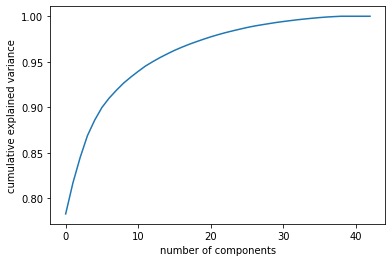

In [15]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We observe that at 10 components, the cumulative explained variance already reaches 0.90. Thus, we decided to use 15 components.

In [16]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=15)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
display(X)
# Compute for the Variance Inflation Factor of each variable
calculate_vif(X)  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.696420,-0.543569,-0.830530,2.943415,-0.903290,0.238887,2.663675,0.812153,3.429692,-0.306524,-1.285449,-0.205307,-0.593380,-0.513786,0.621973
1,1.587596,-2.333203,1.025253,1.215612,1.691928,-0.245996,-0.378067,-0.520318,-0.521157,-2.210893,-0.158055,-0.467904,-0.525701,-0.861083,-0.504562
2,1.854501,-0.992269,-0.440001,0.336069,-0.960559,-1.259283,-1.459209,3.490023,0.634674,-0.604033,0.279331,-0.505439,-0.670426,0.632721,0.674713
3,-2.903551,-0.834788,1.208169,-0.289667,-1.000191,-0.526718,-0.165848,1.593953,-1.732435,-0.949278,1.574539,-0.946548,0.446461,-0.205358,-1.109962
4,-0.545183,-1.688027,0.805115,-1.191339,2.276270,0.940360,1.259853,1.096291,-0.458430,-1.033753,-0.581972,-0.373616,1.476181,0.308488,0.324704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.638757,3.817039,2.060802,-0.964932,-2.112953,-0.889352,-0.052341,-1.538361,1.506659,-1.209759,-1.899117,2.528774,2.839361,-0.795782,0.504704
391,2.571985,3.255018,-0.277192,1.246593,-0.466258,-0.516077,-0.748857,0.638291,-1.247177,0.921436,-0.571157,1.665683,0.065951,-2.024139,-0.201095
392,6.754430,0.754896,0.699553,-0.992947,0.029601,0.965098,1.181412,-3.206676,0.887722,-0.832699,0.458634,-0.350336,1.597532,0.189892,0.697631
393,3.214061,1.891269,-1.566406,1.671802,0.196696,1.165926,-0.110365,-0.548587,-0.141568,0.912515,-0.576730,1.083460,3.012389,-0.860069,-0.088501


,Var,Vif
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
6,6.0,1.0
7,7.0,1.0
8,8.0,1.0
9,9.0,1.0


We observe that the variance inflation factor of the principal components are now low (and uniform) at the value 1.0. Thus, there is no more multicollinearity in the data.

We repeat the splitting process and support vector machine implementation before, using a test size of 0.3 for the splitting.

Accuracy: 0.5882352941176471


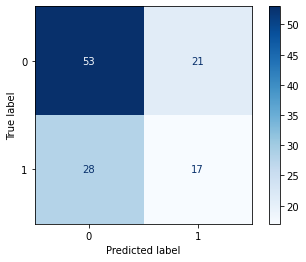

              precision    recall  f1-score   support

           0       0.65      0.72      0.68        74
           1       0.45      0.38      0.41        45

    accuracy                           0.59       119
   macro avg       0.55      0.55      0.55       119
weighted avg       0.58      0.59      0.58       119



In [17]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC(random_state=0)
model.fit(X_train, y_train)

# Compute model predictions
model_predictions = model.predict(X_test)


new_acc_score_no_grid = accuracy_score(y_test, model_predictions)
print("Accuracy:", new_acc_score_no_grid)

# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, model_predictions))

Given the confusion matrix and classification report of the support vector machine, SVC, with default parameters, we observe that this has an accuracy of 0.59, which is significantly lower than the 0.89 obtained using the SVC fitted with the data with G1 and G2, with default parameters. We attempt to increase this by hyper-parameter tuning using GridSearchCV.

In [18]:
# Use GridSearchCV to optimize the parameters of SVC
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ('linear', 'rbf', 'poly', 'sigmoid')} 

# Create grid object
grid = GridSearchCV(SVC(random_state=0), param_grid, refit = True, verbose = 3, n_jobs=-1)
  
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             verbose=3)

### Cross Validation

The GridSearchCV method already performs K-fold cross validation. We show below the mean test scores computed by the cross validation procedure in GridSearchCV.

In [19]:
# Print mean test scores from the results of cross validation in GridSearchCV

new_acc_cv_results = grid.cv_results_['mean_test_score']

print(new_acc_cv_results)

[0.63409091 0.5761039  0.59772727 0.55805195 0.63409091 0.5761039
 0.63785714 0.61227273 0.63409091 0.5761039  0.5761039  0.5761039
 0.63409091 0.5761039  0.5761039  0.5761039  0.63409091 0.5761039
 0.5761039  0.5761039  0.64493506 0.5761039  0.59772727 0.51103896
 0.64493506 0.60883117 0.62681818 0.55792208 0.64493506 0.63045455
 0.5761039  0.64123377 0.64493506 0.5761039  0.5761039  0.5761039
 0.64493506 0.5761039  0.5761039  0.5761039  0.64857143 0.5761039
 0.59772727 0.50350649 0.64857143 0.60142857 0.59772727 0.54344156
 0.64857143 0.62681818 0.59058442 0.63051948 0.64857143 0.62681818
 0.5761039  0.63402597 0.64857143 0.5761039  0.5761039  0.5761039
 0.64857143 0.5761039  0.59772727 0.50376623 0.64857143 0.60142857
 0.59772727 0.54357143 0.64857143 0.59025974 0.63785714 0.60155844
 0.64857143 0.63415584 0.5761039  0.63409091 0.64857143 0.62681818
 0.5761039  0.63402597 0.64493506 0.5761039  0.59772727 0.50376623
 0.64493506 0.60142857 0.59772727 0.54720779 0.64493506 0.62298701
 

### Continuation of GridSearchCV

In [20]:
# Print best parameter after tuning
print(grid.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, gamma=1, kernel='linear', random_state=0)


The SVC model tuned by GridSearchCV has parameters C=10, gamma=1 and kernel='linear'. We now use this model on the test set and observe for increase in accuracy.

Accuracy: 0.5798319327731093


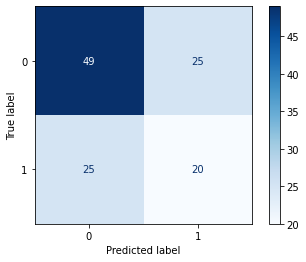

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        74
           1       0.44      0.44      0.44        45

    accuracy                           0.58       119
   macro avg       0.55      0.55      0.55       119
weighted avg       0.58      0.58      0.58       119



In [21]:
# Compute grid predictions
grid_predictions = grid.predict(X_test)

new_acc_score_with_grid = accuracy_score(y_test, grid_predictions)
print("Accuracy:", new_acc_score_with_grid)

# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 

# Print classification report
print(classification_report(y_test, grid_predictions))

Given the confusion matrix and classification report above, we observe that the accuracy of the tuned SVC model, which is 0.58, is lower than the accuracy of the SVC with default parameters with the value of 0.59.

In [34]:
# Displaying the table w/ accuracy scores for comparison

print("Figure 2. Comparison of Accuracy Scores of Variations of the SVM model and the Dataset")

labels = ["SVM", "SVM using GridSearchCV", "Difference (SVM - SVM w/ GridSearchCV)"]
d = {'With G1 & G2': [orig_acc_score_no_grid, orig_acc_score_with_grid, orig_acc_score_no_grid - orig_acc_score_with_grid], 
     'Without G1 & G2': [new_acc_score_no_grid, new_acc_score_with_grid, new_acc_score_no_grid - new_acc_score_with_grid], 
     'Difference (with - without)' : [orig_acc_score_no_grid - new_acc_score_no_grid, orig_acc_score_with_grid - new_acc_score_with_grid,
                    (orig_acc_score_no_grid - new_acc_score_no_grid)-(orig_acc_score_with_grid - new_acc_score_with_grid)]}

df = pd.DataFrame(data=d, index=labels)

df

Figure 2. Comparison of Accuracy Scores of Variations of the SVM model and the Dataset


,With G1 & G2,Without G1 & G2,Difference (with - without)
SVM,0.890756,0.588235,0.302521
SVM using GridSearchCV,0.890756,0.579832,0.310924
Difference (SVM - SVM w/ GridSearchCV),0.000000,0.008403,-0.008403


In Figure 2 above, the table shows the summary of accuracy scores obtained using different variations of the SVM model and the dataset. In general, it can be seen that the accuracy scores produced by the analysis of the dataset with the attributes G1 & G2 (grade in 1st period and grade in 2nd period) are HIGHER than the accurracy scores produced by analysis of the dataset without the attributes G1 & G2. 

For the default SVM model, the difference between the accuracy scores is 0.302521. For SVM using GridSearchCV, the difference between the accuracy scores is 0.310924. 

Using the original dataset with G1 & G2, there is NO difference between the accuracy scores produced by SVM and SVM using GridSearchCV. Hwoever, when G1 & G2 were removed from the dataset, a difference of 0.008403 is obtained. The accuracy score resulting from the SVM using GridSearchCV is LOWER than the accuracy score resulting from the default SVM.

This is surprising because GridSearchCV was used to tune the hyperparamater and attempt to achieve higher accuracy. However, the results were the opposite.

## Conclusion


Based on the data & analysis, the accuracy scores produced by the analysis of the dataset with the attributes G1 & G2 (grade in 1st period and grade in 2nd period) are HIGHER than the accurracy scores produced by analysis of the dataset without the attributes G1 & G2. The differences between the accuracy scores are 30.2521 % and 31.0924%, showing an approximate 30% decrease. 

It can be concluded that the attributes G1 & G2 have HIGH impact on the target output. This is further supported by the correlation matrix heatmap in Figure 1, which showed that G1 & G2 both have a 76% correlation level with respect to the target output QUALITY. This is because QUALITY is an interpretation of attribute G3 (final grade), and G3 in turn is VERY HIGHLY correlated to G1 and G2, with correlation levels of 80% and 90%, respectively. It can be said that QUALITY is dependent on the two attributes.

## Individual Contributions